In [1]:
import numpy as np
from scipy.interpolate import interp1d as interp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from thunderflask import thunderflask
from bacteria import strain
from ffgen import ffgen
from codonTable import codonTable
from codonUtils import utils
from bacteria import strain
from ffgen import ffgen
import pickle
from codonOptimizer import tableOptimizer
from queue import Queue as queue
from random import choice
from matplotlib.colors import LinearSegmentedColormap as LSC
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cProfile
import copy
from scipy.signal import gaussian
from scipy.ndimage import convolve1d
import peakutils
from peakutils.plot import plot as pplot
%matplotlib inline

In [2]:
with open('res/2-14 Traces/2-22_Standard Code_favg_traces_T=1000_N=10_b=1_l=2.pickle', 'rb') as handle:
    standard_df = pickle.load(handle)
    
with open('res/2-14 Traces/2-22_Fast Fail Code_favg_traces_T=1000_N=10_b=1_l=2.pickle', 'rb') as handle:
    fastfail_df = pickle.load(handle)
    
with open('res/2-14 Traces/2-22_Reductionist Code_favg_traces_T=1000_N=10_b=1_l=2.pickle', 'rb') as handle:
    reductionist_df = pickle.load(handle)

with open('res/2-14 Traces/2-27_Redone Fast Fail Code 20AA_favg_traces_T=1000_N=10_b=1_l=2.pickle', 'rb') as handle:
    redonefastfail_df = pickle.load(handle)
    
with open('res/2-14 Traces/2-27_Fast Fail Biocontainment Code 3_favg_traces_T=1000_N=10_b=1_l=2.pickle', 'rb') as handle:
    ffBC3_df = pickle.load(handle)

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


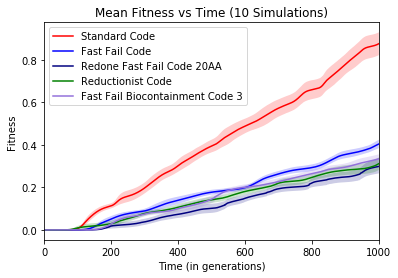

In [3]:
ax1 = sns.tsplot(data=standard_df, time='time', value='value', unit='sim', condition='code', color='red')
ax2 = sns.tsplot(data=fastfail_df, time='time', value='value', unit='sim', condition='code', color='blue')
ax3 = sns.tsplot(data=redonefastfail_df, time='time', value='value', unit='sim', condition='code', color='navy')
ax4 = sns.tsplot(data=reductionist_df, time='time', value='value', unit='sim', condition='code', color='green')
ax5 = sns.tsplot(data=ffBC3_df, time='time', value='value', unit='sim', condition='code', color='mediumpurple')
plt.legend()
plt.title('Mean Fitness vs Time (10 Simulations)')
plt.xlabel('Time (in generations)')
plt.ylabel('Fitness')
plt.savefig('res/2-27_F_avg_All_Sims_T=500_b=2_l=3-5.pdf', bbox_inches='tight')
plt.show()

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


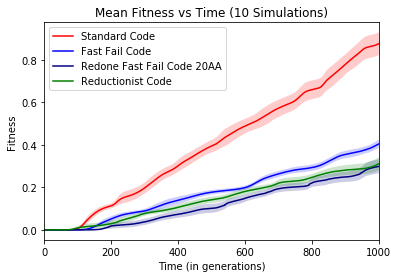

In [4]:
ax1 = sns.tsplot(data=standard_df, time='time', value='value', unit='sim', condition='code', color='red')
ax2 = sns.tsplot(data=fastfail_df, time='time', value='value', unit='sim', condition='code', color='blue')
ax3 = sns.tsplot(data=redonefastfail_df, time='time', value='value', unit='sim', condition='code', color='navy')
ax4 = sns.tsplot(data=reductionist_df, time='time', value='value', unit='sim', condition='code', color='green')
plt.legend()
plt.title('Mean Fitness vs Time (10 Simulations)')
plt.xlabel('Time (in generations)')
plt.ylabel('Fitness')
plt.savefig('res/2-27_F_avg_FF_Compare_W_sc_T=500_b=2_l=3-5.pdf', bbox_inches='tight')
plt.show()

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


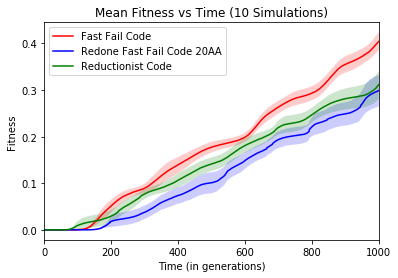

In [5]:
ax1 = sns.tsplot(data=fastfail_df, time='time', value='value', unit='sim', condition='code', color='red')
ax2 = sns.tsplot(data=redonefastfail_df, time='time', value='value', unit='sim', condition='code', color='blue')
ax3 = sns.tsplot(data=reductionist_df, time='time', value='value', unit='sim', condition='code', color='green')
plt.legend()
plt.title('Mean Fitness vs Time (10 Simulations)')
plt.xlabel('Time (in generations)')
plt.ylabel('Fitness')
plt.savefig('res/2-27_F_avg_FF_Compare_W_rd_T=500_b=2_l=3-5.pdf', bbox_inches='tight')
plt.show()

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


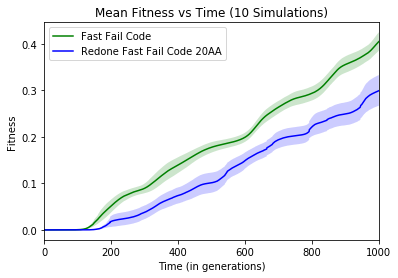

In [6]:
ax1 = sns.tsplot(data=fastfail_df, time='time', value='value', unit='sim', condition='code', color='green')
ax2 = sns.tsplot(data=redonefastfail_df, time='time', value='value', unit='sim', condition='code', color='blue')
plt.legend()
plt.title('Mean Fitness vs Time (10 Simulations)')
plt.xlabel('Time (in generations)')
plt.ylabel('Fitness')
plt.savefig('res/2-27_F_avg_FF_Compare_T=500_b=2_l=3-5.pdf', bbox_inches='tight')
plt.show()

In [7]:
filename = 'res/2-14 Traces/2-22_Standard Code_favg_traces_T=1000_N=10_b=1_l=2.pickle'
with open(filename, 'rb') as handle:
    df = pickle.load(handle)

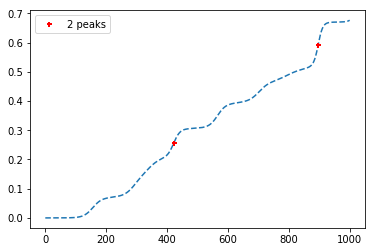

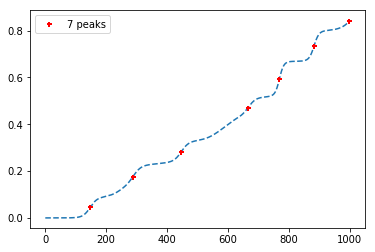

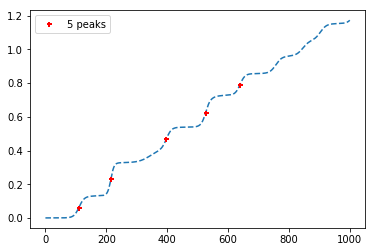

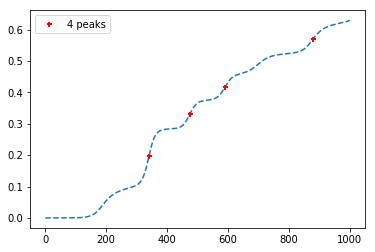

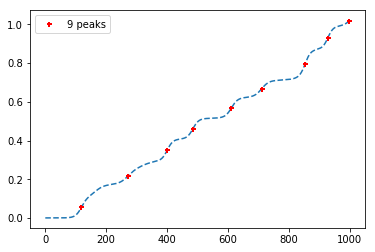

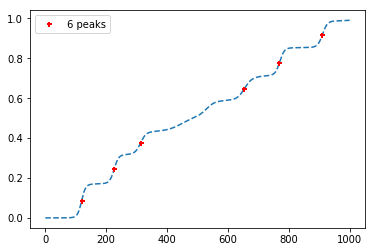

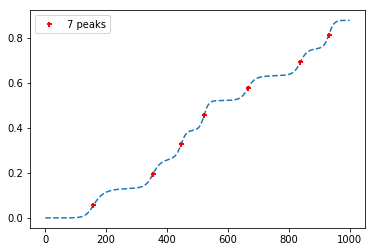

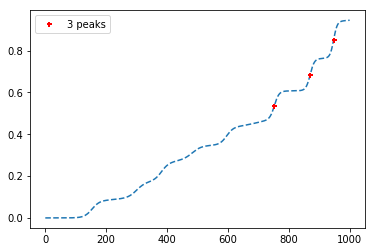

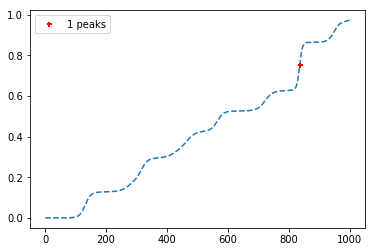

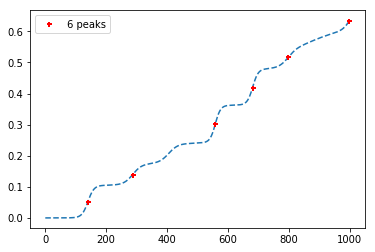

In [8]:
# loop over sims
sims = set(df['sim'].values)
t_lag = np.zeros(len(sims))
for i, sim in enumerate(sims):
    # extract data for this sim
    data = df[df['sim'] == sim]
    t = data['time'].values
    f = data['value'].values
    # smooth with gaussian filter
    gaussian_filter = gaussian(30, 10)
    filtered_signal = convolve1d(f, gaussian_filter/gaussian_filter.sum())
    # calculate first derivative  
    dt = np.diff(t)
    t_avg = (t[1:]+t[:-1])/2
    filt_grad = np.diff(filtered_signal)/dt
    # find peaks
    peak_ind = peakutils.indexes(filt_grad, thres=0.3, min_dist=int(50/dt.mean()))
    # get timestamp for this point
    t_lag[i] = t_avg[peak_ind[0]]
    pplot(t, f, peak_ind)
    plt.show()

In [9]:
t_sc = t_lag

In [10]:
filename = 'res/2-14 Traces/2-22_Fast Fail Code_favg_traces_T=1000_N=10_b=1_l=2.pickle'
with open(filename, 'rb') as handle:
    df = pickle.load(handle)

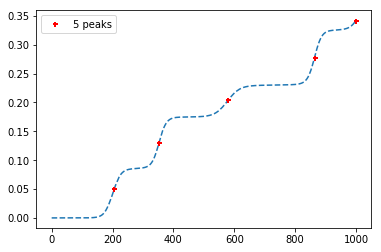

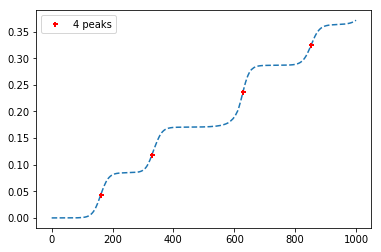

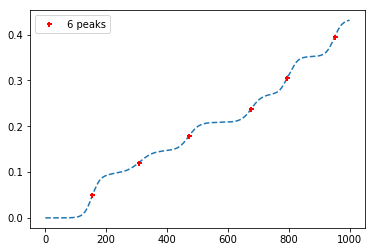

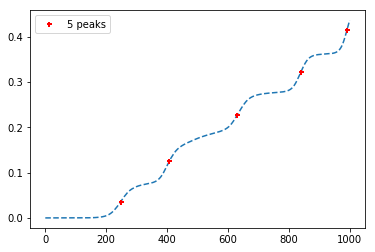

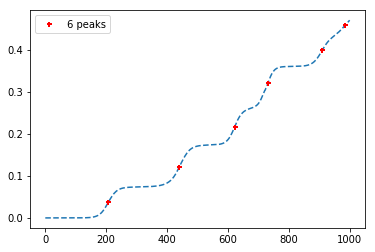

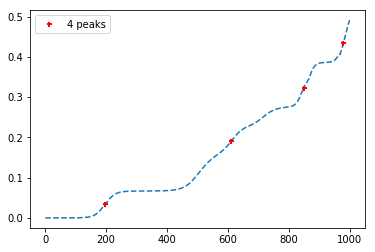

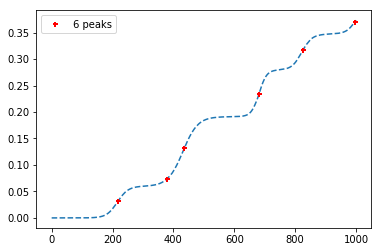

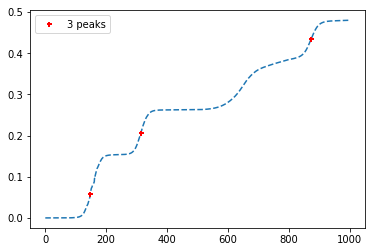

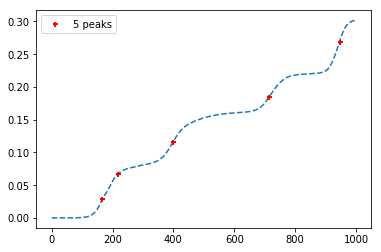

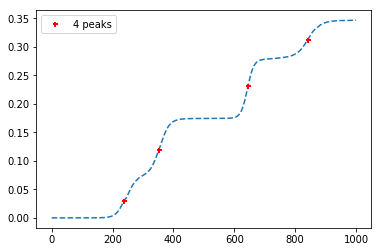

In [11]:
# loop over sims
sims = set(df['sim'].values)
t_lag = np.zeros(len(sims))
for i, sim in enumerate(sims):
    # extract data for this sim
    data = df[df['sim'] == sim]
    t = data['time'].values
    f = data['value'].values
    # smooth with gaussian filter
    gaussian_filter = gaussian(30, 10)
    filtered_signal = convolve1d(f, gaussian_filter/gaussian_filter.sum())
    # calculate first derivative  
    dt = np.diff(t)
    t_avg = (t[1:]+t[:-1])/2
    filt_grad = np.diff(filtered_signal)/dt
    # find peaks
    peak_ind = peakutils.indexes(filt_grad, thres=0.3, min_dist=int(50/dt.mean()))
    # get timestamp for this point
    t_lag[i] = t_avg[peak_ind[0]]
    pplot(t, f, peak_ind)
    plt.show()

In [12]:
t_ff = t_lag

In [13]:
filename = 'res/2-14 Traces/2-22_Reductionist Code_favg_traces_T=1000_N=10_b=1_l=2.pickle'
with open(filename, 'rb') as handle:
    df = pickle.load(handle)

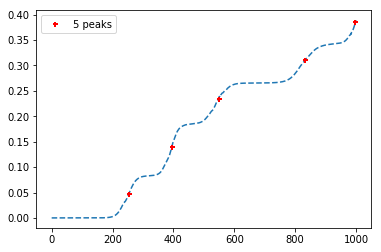

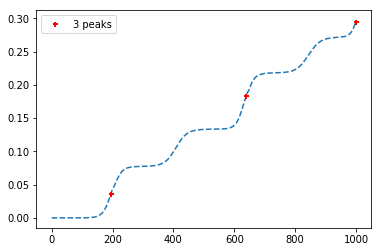

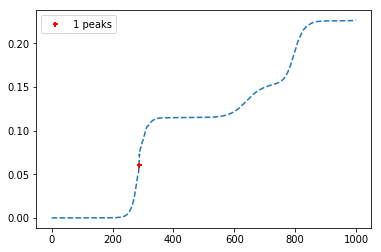

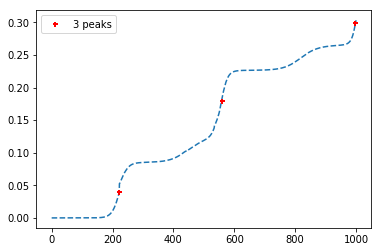

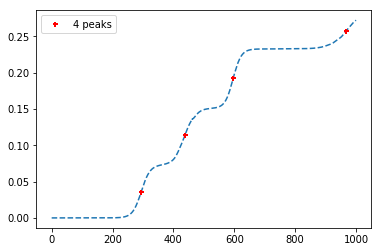

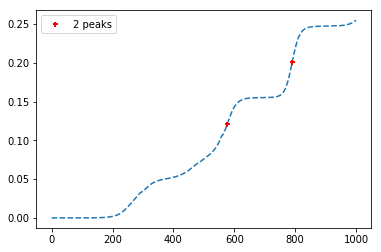

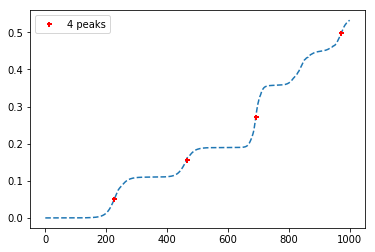

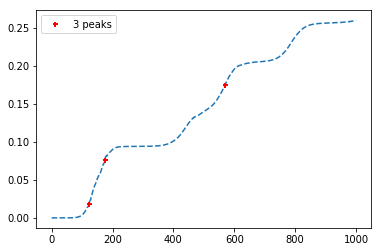

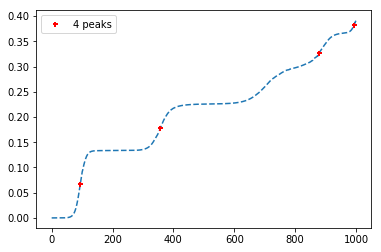

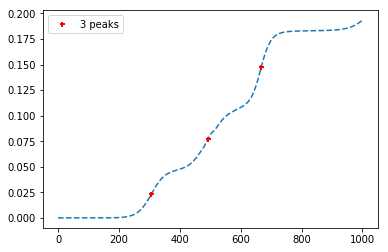

In [14]:
# loop over sims
sims = set(df['sim'].values)
t_lag = np.zeros(len(sims))
for i, sim in enumerate(sims):
    # extract data for this sim
    data = df[df['sim'] == sim]
    t = data['time'].values
    f = data['value'].values
    # smooth with gaussian filter
    gaussian_filter = gaussian(30, 10)
    filtered_signal = convolve1d(f, gaussian_filter/gaussian_filter.sum())
    # calculate first derivative  
    dt = np.diff(t)
    t_avg = (t[1:]+t[:-1])/2
    filt_grad = np.diff(filtered_signal)/dt
    # find peaks
    peak_ind = peakutils.indexes(filt_grad, thres=0.3, min_dist=int(50/dt.mean()))
    # get timestamp for this point
    t_lag[i] = t_avg[peak_ind[0]]
    pplot(t, f, peak_ind)
    plt.show()

In [15]:
t_rc = t_lag

In [16]:
filename = 'res/2-14 Traces/2-27_Redone Fast Fail Code 20AA_favg_traces_T=1000_N=10_b=1_l=2.pickle'
with open(filename, 'rb') as handle:
    df = pickle.load(handle)

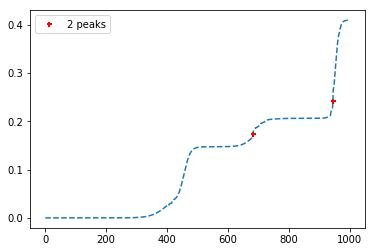

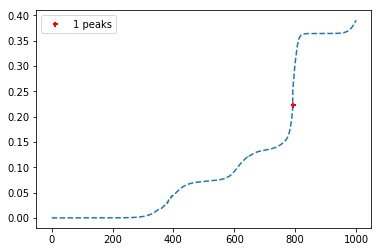

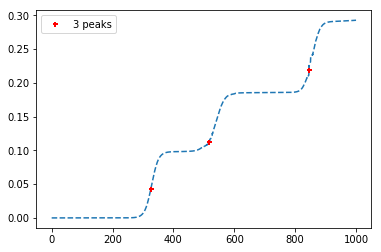

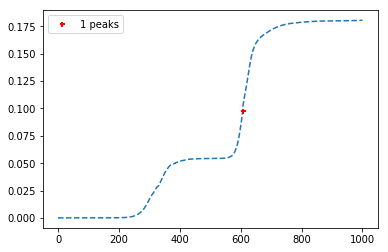

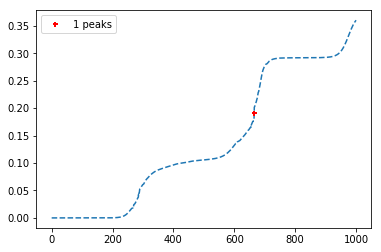

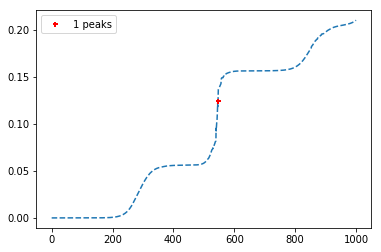

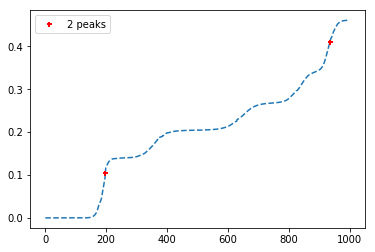

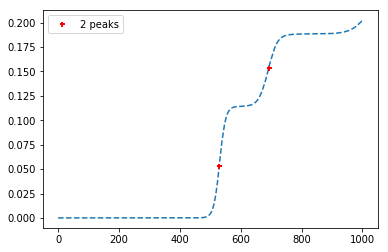

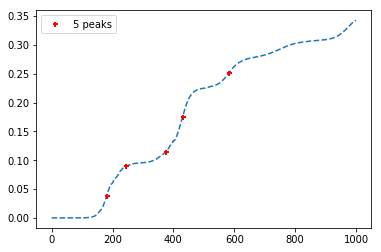

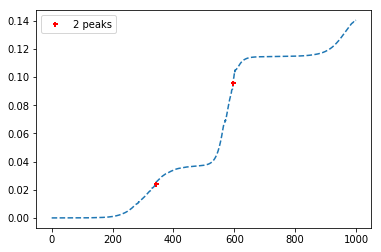

In [17]:
# loop over sims
sims = set(df['sim'].values)
t_lag = np.zeros(len(sims))
for i, sim in enumerate(sims):
    # extract data for this sim
    data = df[df['sim'] == sim]
    t = data['time'].values
    f = data['value'].values
    # smooth with gaussian filter
    gaussian_filter = gaussian(30, 10)
    filtered_signal = convolve1d(f, gaussian_filter/gaussian_filter.sum())
    # calculate first derivative  
    dt = np.diff(t)
    t_avg = (t[1:]+t[:-1])/2
    filt_grad = np.diff(filtered_signal)/dt
    # find peaks
    peak_ind = peakutils.indexes(filt_grad, thres=0.3, min_dist=int(50/dt.mean()))
    # get timestamp for this point
    t_lag[i] = t_avg[peak_ind[0]]
    pplot(t, f, peak_ind)
    plt.show()

In [18]:
t_rff = t_lag

In [19]:
filename = 'res/2-14 Traces/2-27_Fast Fail Biocontainment Code 3_favg_traces_T=1000_N=10_b=1_l=2.pickle'
with open(filename, 'rb') as handle:
    df = pickle.load(handle)

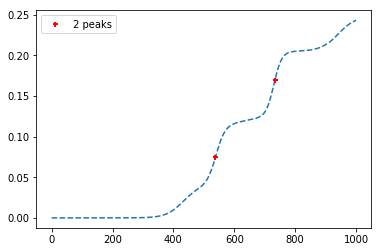

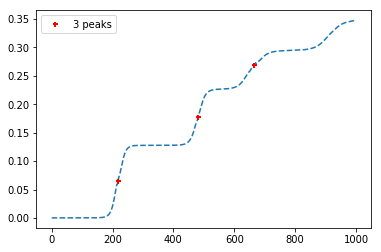

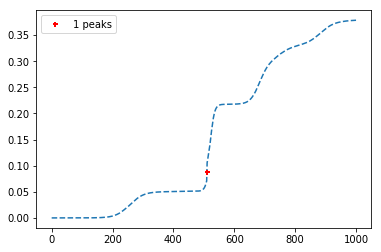

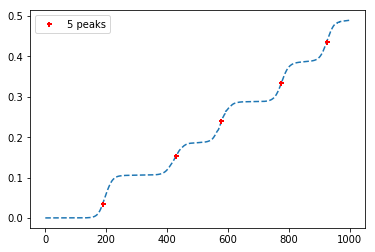

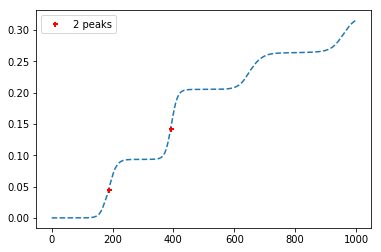

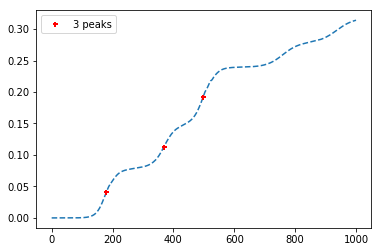

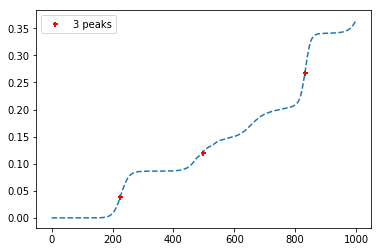

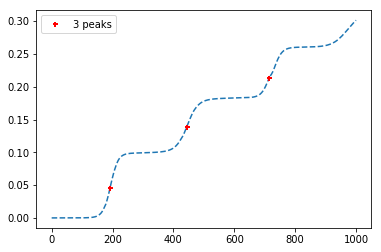

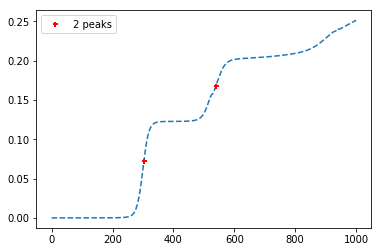

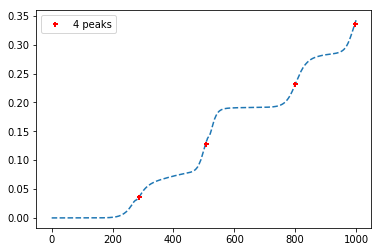

In [20]:
# loop over sims
sims = set(df['sim'].values)
t_lag = np.zeros(len(sims))
for i, sim in enumerate(sims):
    # extract data for this sim
    data = df[df['sim'] == sim]
    t = data['time'].values
    f = data['value'].values
    # smooth with gaussian filter
    gaussian_filter = gaussian(30, 10)
    filtered_signal = convolve1d(f, gaussian_filter/gaussian_filter.sum())
    # calculate first derivative  
    dt = np.diff(t)
    t_avg = (t[1:]+t[:-1])/2
    filt_grad = np.diff(filtered_signal)/dt
    # find peaks
    peak_ind = peakutils.indexes(filt_grad, thres=0.3, min_dist=int(50/dt.mean()))
    # get timestamp for this point
    t_lag[i] = t_avg[peak_ind[0]]
    pplot(t, f, peak_ind)
    plt.show()

In [21]:
t_bc = t_lag

In [29]:
data = [t_sc, t_ff, t_rc, t_bc, t_rff ]
codes = ['Standard','Fast Fail','Reductionist', 'Fast Fail Biocontainment','Redone Fast Fail']
dfs = []
for (series, code) in zip(data, codes):
    df = pd.DataFrame({
        't_lag' : series,
        'code' : [code for i in range(len(series))]
    })
    dfs.append(df)
all_data = pd.concat(dfs)

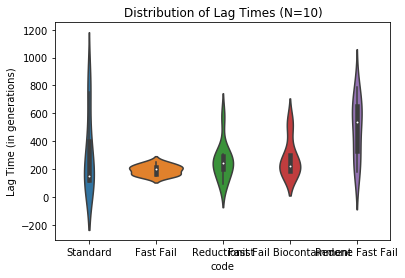

In [30]:
ax = sns.violinplot(x='code', y='t_lag', data=all_data)
plt.title('Distribution of Lag Times (N=10)')
plt.ylabel('Lag Time (in generations)')
plt.savefig('ViolinAllCodes.pdf')

In [31]:
data = [t_sc, t_ff, t_rc, t_rff ]
codes = ['Standard','Fast Fail','Reductionist','Redone Fast Fail']
dfs = []
for (series, code) in zip(data, codes):
    df = pd.DataFrame({
        't_lag' : series,
        'code' : [code for i in range(len(series))]
    })
    dfs.append(df)
all_data = pd.concat(dfs)

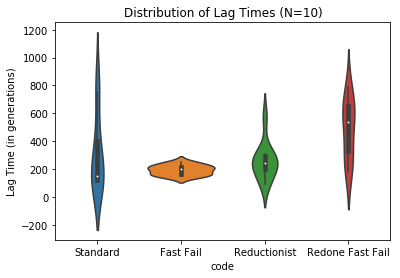

In [32]:
ax = sns.violinplot(x='code', y='t_lag', data=all_data)
plt.title('Distribution of Lag Times (N=10)')
plt.ylabel('Lag Time (in generations)')
plt.savefig('ViolinFFwSC.pdf')

In [33]:
data = [t_ff, t_rc, t_rff ]
codes = ['Fast Fail','Reductionist','Redone Fast Fail']
dfs = []
for (series, code) in zip(data, codes):
    df = pd.DataFrame({
        't_lag' : series,
        'code' : [code for i in range(len(series))]
    })
    dfs.append(df)
all_data = pd.concat(dfs)

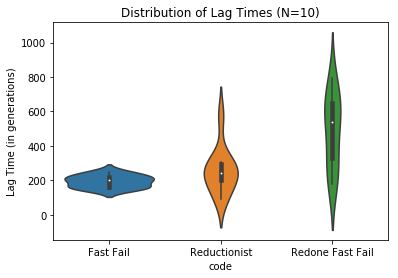

In [34]:
ax = sns.violinplot(x='code', y='t_lag', data=all_data)
plt.title('Distribution of Lag Times (N=10)')
plt.ylabel('Lag Time (in generations)')
plt.savefig('ViolinFF.pdf')

In [35]:
data = [t_ff, t_rff ]
codes = ['Fast Fail','Redone Fast Fail']
dfs = []
for (series, code) in zip(data, codes):
    df = pd.DataFrame({
        't_lag' : series,
        'code' : [code for i in range(len(series))]
    })
    dfs.append(df)
all_data = pd.concat(dfs)

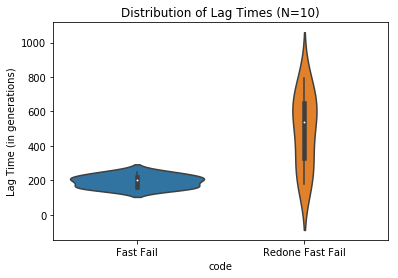

In [36]:
ax = sns.violinplot(x='code', y='t_lag', data=all_data)
plt.title('Distribution of Lag Times (N=10)')
plt.ylabel('Lag Time (in generations)')
plt.savefig('ViolinFFvsRFF.pdf')